The first code block is for updating packages and reinitiate the development environment on a newly install system. Please don't run the code frequently, or it may lead to some unexpected behaviors and break the environment.

In [1]:
# using Pkg
# Pkg.activate("..")
# Pkg.instantiate()
# Pkg.update()

In [2]:
using Cropbox
using Test
# using Plots
using TimeZones
using DataFramesMeta
using CSV

# Cropbox.Interact.WebIO.setup(:ijulia)

In [3]:
include("../src/Garttuce.jl")

using Dates

┌ Warning: duplicate variable
│   system = Mass
│   name = living_total_mass
│   alias = nothing => nothing
│   state = :Track => :Track
└ @ Cropbox /Users/cariso27001/.julia/packages/Cropbox/aE8bI/src/macro.jl:690


In [4]:
Lettuce = @config (
# # CV PHYL ILN GLN LL LER SG SD LTAR LTARa LIR Topt Tceil critPPD
# KM1 134 4 10 65.0 4.70 1.84 122 0 0.4421 0.1003 22.28 34.23 12
    :Phenology => (
        emergence_optimal_temperature = 15.0,
        emergence_ceiling_temperature = 28.0,
        optimal_temperature = 15, # Topt
        ceiling_temperature = 28, # Tceil
        critical_photoperiod = 24, # critPPD
        maximum_leaf_initiation_rate = 0.943214,
        # maximum_leaf_initiation_rate = 0.979699,
        # maximum_emergence_rate = 0.02,
        maximum_phyllochron_asymptote = 0.802838,
        # maximum_phyllochron_asymptote = 0.603197,
        leaves_generic = 28, # GLN
    ),
    :Leaf => (
        maximum_elongation_rate = 4.7,
        minimum_length_of_longest_leaf = 26.4, # LL
        stay_green = 3.5,
        length_to_width_ratio = 0.8,
    ),
    :Carbon => (
# # Rm Yg
# 0.012 0.8
        maintenance_respiration_coefficient = 0.012, # Rm
        synthesis_efficiency = 0.8, # Yg
        partitioning_table = [
        # root leaf stem
          0.00 0.00 0.00 ; # seed garlic before germination
          0.15 0.60 0.25 ; # vegetative stage
          0.00 0.00 0.00 ; # dead
        ],
    ),
);

In [5]:
ConstructA = @config(Lettuce, (
    :Phenology => (
        planting_date = ZonedDateTime(2021, 10, 12, tz"Asia/Taipei"),
        emergence_date = ZonedDateTime(2021, 10, 24, tz"Asia/Taipei"),
    ),
    :Meta => (
        planting_group = 1,
        year = 2021,
    ),
    :Calendar => (
        init = ZonedDateTime(2021, 10, 12, 18, tz"Asia/Taipei"),
        last = ZonedDateTime(2021, 12, 19, tz"Asia/Taipei"),
    ),
    :Weather => (
        CO2 = 390,
        store = Garttuce.loadwea("$(@__DIR__)/../data/winter2021.wea", tz"Asia/Taipei"),
    ),
    :Plant => (initial_planting_density = 55,),
));

In [6]:
ConstructB = @config(Lettuce, (
    :Phenology => (
        planting_date = ZonedDateTime(2022, 3, 7, tz"Asia/Taipei"),
        emergence_date = ZonedDateTime(2022, 4, 10, tz"Asia/Taipei"),
    ),
    :Meta => (
        planting_group = 1,
        year = 2022,
    ),
    :Calendar => (
        init = ZonedDateTime(2022, 3, 7, 23, tz"Asia/Taipei"),
        last = ZonedDateTime(2022, 5, 28, tz"Asia/Taipei"),
    ),
    :Weather => (
        CO2 = 390,
        store = Garttuce.loadwea("$(@__DIR__)/../data/spring2022.wea", tz"Asia/Taipei"),
    ),
    :Plant => (initial_planting_density = 55,),
));

In [6]:
obs_leafnum = CSV.read("$(@__DIR__)/../data/OBS_Winter2021/winter2021_leafnum_consistent.csv", DataFrame) |> unitfy

f(s) = s.DAP' in obs_leafnum.DAP && Dates.hour(s.calendar.time') == 12

# r = simulate(Garlic.Model;
calibrate(Garttuce.Model, obs_leafnum;
    config=ConstructA,
    parameters= :Phenology => (;
        LTARa_max = (0.1,1.5),
        LIR_max = (0.2,1.5),
    ),
    stop="calendar.count",
    index=:DAP,
    target=:Appeared_mean => :leaves_appeared,
    snap=f,
    optim=(:MaxSteps => 50,),
)

InterruptException: InterruptException:

Progress:   1%[>                          ]  ETA: 0:05:46 ( 0.22  s/it)

Progress:  63%[=================>         ]  ETA: 0:00:04 ( 7.10 ms/it)

Progress: 100%[===========================] Time: 0:00:08 ( 4.99 ms/it)


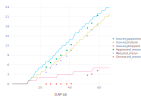

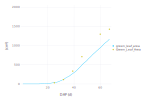

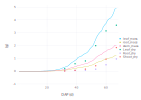

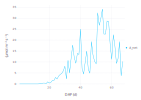

In [7]:
obs_drymass = CSV.read("$(@__DIR__)/../data/OBS_Winter2021/winter2021_DryMass.csv", DataFrame) |> unitfy
obs_area = CSV.read("$(@__DIR__)/../data/OBS_Winter2021/winter2021_Area.csv", DataFrame) |> unitfy
obs_leafnum = CSV.read("$(@__DIR__)/../data/OBS_Winter2021/winter2021_leafnum_consistent.csv", DataFrame) |> unitfy

r = simulate(Garttuce.Model;
    config=ConstructA,
    stop="calendar.count",
    snap=s -> Dates.hour(s.calendar.time') == 12,
)
@test r.leaves_initiated[end] > 0

sln = visualize(r, :DAP, [:leaves_appeared, :leaves_mature, :leaves_dropped], kind=:line) # Fig. Leaf Number
visualize!(sln, obs_leafnum, :DAP, [:Appeared_mean, :Matured_mean, :Senesced_mean]) |> display # Fig. Leaf Area
sa = visualize(r, :DAP, :green_leaf_area, kind=:line, ylim = (0,2000))
visualize!(sa, obs_area, :DAP, [:Green_Leaf_Area]) |> display # Fig. Leaf Area
sb = visualize(r, :DAP, [:leaf_mass, :root_mass, :stem_mass], kind=:line)
visualize!(sb, obs_drymass, :DAP, [:Leaf_dry, :Root_dry, :Shoot_dry]) |> display # Fig. Biomass
visualize(r, :DAP, [:A_net], kind=:line) |> display

Progress:  48%[=============>             ]  ETA: 0:00:01 ( 1.15 ms/it)

Progress:  93%[=========================> ]  ETA: 0:00:00 ( 1.27 ms/it)

Progress: 100%[===========================] Time: 0:00:02 ( 1.28 ms/it)


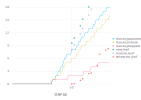

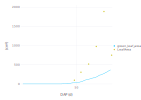

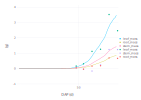

In [8]:
obs_leafnum = CSV.read("$(@__DIR__)/../data/OBS_Spring2022/spring2022_leafnum_consistent.csv", DataFrame) |> unitfy
obs_drymass = CSV.read("$(@__DIR__)/../data/OBS_Spring2022/spring2022_DryMass.csv", DataFrame) |> unitfy
obs_area = CSV.read("$(@__DIR__)/../data/OBS_Spring2022/spring2022_Area.csv", DataFrame) |> unitfy

r = simulate(Garttuce.Model;
    config=ConstructB,
    stop="calendar.count",
    snap=s -> Dates.hour(s.calendar.time') == 12,
)
@test r.leaves_initiated[end] > 0

sln = visualize(r, :DAP, [:leaves_appeared, :leaves_mature, :leaves_dropped], kind=:line) # Fig. Leaf Number
visualize!(sln, obs_leafnum, :DAP, [:new_leaf, :mature_leaf, :senesced_leaf]) |> display # Fig. Leaf Area
sa = visualize(r, :DAP, :green_leaf_area, kind=:line, ylim = (0,2000))
visualize!(sa, obs_area, :DAP, [:LeafArea]) |> display # Fig. Leaf Area
sb = visualize(r, :DAP, [:leaf_mass, :root_mass, :stem_mass], kind=:line)
visualize!(sb, obs_drymass, :DAP, [:leaf_mass, :stem_mass, :root_mass]) |> display # Fig. Biomass

In [10]:
CSV.write("$(@__DIR__)/../SimExport.csv", r)

"/home/cariso27001/CropModeling/Garttuce/test/../SimExport.csv"

In [70]:
# Cropbox.Unitful.ustrip.(r.leaves_initiated)

In [18]:
# evaluate(obs_leafnum, r; index = :DAP, target = :Appeared_mean => :leaves_appeared, metric=:ef) |> display
# evaluate(obs_leafnum, r; index = :DAP, target = :Appeared_mean => :leaves_appeared, metric=:rmse) |> display
# evaluate(obs_leafnum, r; index = :DAP, target = :Matured_mean => :leaves_mature, metric=:ef) |> display
# evaluate(obs_leafnum, r; index = :DAP, target = :Matured_mean => :leaves_mature, metric=:rmse) |> display
# evaluate(obs_leafnum, r; index = :DAP, target = :Senesced_mean => :leaves_dropped, metric=:ef) |> display
# evaluate(obs_leafnum, r; index = :DAP, target = :Senesced_mean => :leaves_dropped, metric=:rmse) |> display

# evaluate(obs_area, r; index = :DAP, target = :Green_Leaf_Area => :green_leaf_area, metric=:ef) |> display
# evaluate(obs_area, r; index = :DAP, target = :Green_Leaf_Area => :green_leaf_area, metric=:rmse) |> display

# evaluate(obs_drymass, r; index = :DAP, target = :Leaf_dry => :leaf_mass, metric=:ef) |> display
# evaluate(obs_drymass, r; index = :DAP, target = :Leaf_dry => :leaf_mass, metric=:rmse) |> display
# evaluate(obs_drymass, r; index = :DAP, target = :Shoot_dry => :shoot_mass, metric=:ef) |> display
# evaluate(obs_drymass, r; index = :DAP, target = :Shoot_dry => :shoot_mass, metric=:rmse) |> display
# evaluate(obs_drymass, r; index = :DAP, target = :Root_dry => :root_mass, metric=:ef) |> display
# evaluate(obs_drymass, r; index = :DAP, target = :Root_dry => :root_mass, metric=:rmse) |> display

In [17]:
# Cropbox.Interact.WebIO.setup(:ijulia)

# manipulate(Garttuce.Model, :DAP, [:leaves_appeared, :leaves_mature, :leaves_dropped];
#     config = ConstructB,
#     parameters = :Phenology => (;
#         optimal_temperature = 10:40,
        
#     )
#     stop = "calendar.count",
#     kind = :line,
# )

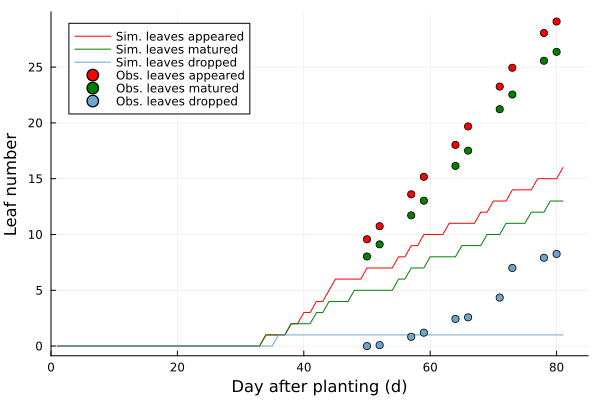

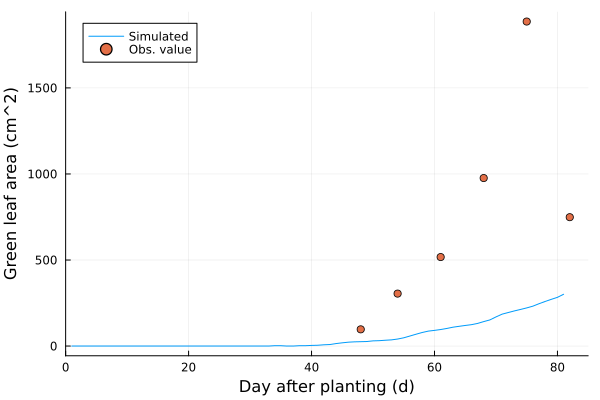

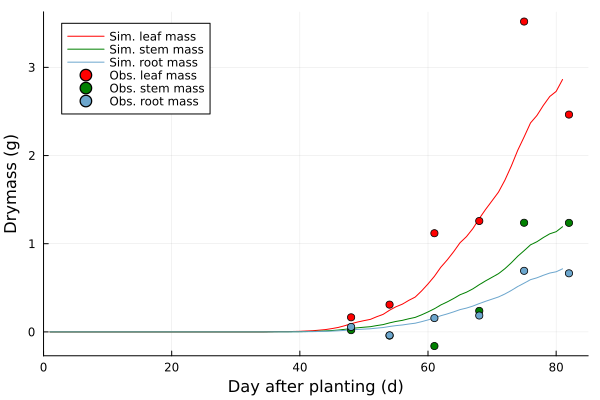

"/home/cariso27001/CropModeling/Garttuce/Spring2022_Drymass.svg"

In [83]:
using Plots

LeafN = Plots.plot(r.DAP, r.leaves_appeared,
    ylabel = "Leaf number", 
    xlabel = "Day after planting",
    label  = "Sim. leaves appeared", color = "red", xlim=[0,85])
LeafN = Plots.plot!(LeafN, r.DAP, r.leaves_mature, label="Sim. leaves matured", color = "green")
LeafN = Plots.plot!(LeafN, r.DAP, r.leaves_dropped, label="Sim. leaves dropped", color = "skyblue3")
LeafN = Plots.plot!(LeafN, obs_leafnum.DAP, obs_leafnum.new_leaf, label="Obs. leaves appeared", line = :scatter, color = "red")
LeafN = Plots.plot!(LeafN, obs_leafnum.DAP, obs_leafnum.mature_leaf, label="Obs. leaves matured", line = :scatter, color = "green")
LeafN = Plots.plot!(LeafN, obs_leafnum.DAP, obs_leafnum.senesced_leaf, label="Obs. leaves dropped", line = :scatter, color = "skyblue3") |> display
savefig("../Spring2022_LeafNum.svg")


LeafA = Plots.plot(r.DAP, r.green_leaf_area,
    ylabel = "Green leaf area", 
    xlabel = "Day after planting",
    label  = "Simulated", xlim=[0,85])
LeafA = Plots.plot!(LeafA, obs_area.DAP, obs_area.LeafArea, label="Obs. value", line = :scatter) |> display
savefig("../Spring2022_LeafArea.svg")

PlantB = Plots.plot(r.DAP, r.leaf_mass,
    ylabel = "Drymass", 
    xlabel = "Day after planting",
    label  = "Sim. leaf mass", color = "red", xlim=[0,85])
PlantB = Plots.plot!(PlantB, r.DAP, r.stem_mass, label="Sim. stem mass", color = "green")
PlantB = Plots.plot!(PlantB, r.DAP, r.root_mass, label="Sim. root mass", color = "skyblue3")
PlantB = Plots.plot!(PlantB, obs_drymass.DAP, obs_drymass.leaf_mass, label="Obs. leaf mass", line = :scatter, color = "red")
PlantB = Plots.plot!(PlantB, obs_drymass.DAP, obs_drymass.stem_mass, label="Obs. stem mass", line = :scatter, color = "green")
PlantB = Plots.plot!(PlantB, obs_drymass.DAP, obs_drymass.root_mass, label="Obs. root mass", line = :scatter, color = "skyblue3") |> display
savefig("../Spring2022_Drymass.svg")